# Исследование успешности компьютерной игры

**Цель проекта**: выявить параметры, которые определяют успешность игры для выбора потенциально успешного продукта на 2017 год.

**Задачи**:

- провести анализ данных:
    - проданных копий;
    - игр по годам выхода;
    - игровых платформ;
    - периода "жизни" платформ;
- составить портрет пользователя по трем регионам (Северная Америка, Европа и Япония);
- проверить гипотезы о рейтингах двух платформ (Xbox One и PC) и двух жанров (Action и Sports) в зависимости от рейтинга пользователей.

Для исследования предоставлены данные до 2016 года.

## Оглавление <a id="contents"></a>

1. [Открытие файла и изучение общей информации](#start)
2. [Предобработка данных](#preprocessing)
    * [Замена названий и типов данных столбцов](#rename)
    * [Обработка пропусков](#nan)
    * [Добавление в таблицу новых значений](#add)
3. [Проведение исследовательского анализа данных](#research)
    * [Анализ распределения проданных копий](#copies)
    * [Анализ игр по годам](#years)
    * [Анализ игровых платформ](#platforms)
    * [Исследование актуального периода](#current_period)
        - [Исследование платформ](#current_platforms)
        - [Исследование зависимости продаж и оценок](#current_platform)
        - [Исследование распределения игр по жанрам](#current_genre)
4. [Составление портрета пользаветеля каждого региона](#users)
    * [Северная Америка](#america)
    * [Европа](#europe)
    * [Япония](#japan)
5. [Проверка гипотез](#hypothesis)
    * [Гипотеза 1: средние пользовательские рейтинги платформ Xbox One и PC одинаковые](#hypothesis_1)
    * [Гипотеза 2: средние пользовательские рейтинги жанров Action и Sports разные](#hypothesis_2)
6. [Общий вывод и рекомендации](#conclusion)

## 1. Открытие файла и изучение общей информации <a id="start"></a>

Перед началом работы импортируем необходимые библиотеки и компоненты.

In [1]:
import pandas as pd
import numpy as np
from scipy import stats as st
from matplotlib import pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

Сохраним датасет в переменной `df`, выведем первые пять строк, а также общую информацию по датасету.

In [2]:
df = pd.read_csv('/datasets/games.csv', sep = ',')
df.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
Name               16713 non-null object
Platform           16715 non-null object
Year_of_Release    16446 non-null float64
Genre              16713 non-null object
NA_sales           16715 non-null float64
EU_sales           16715 non-null float64
JP_sales           16715 non-null float64
Other_sales        16715 non-null float64
Critic_Score       8137 non-null float64
User_Score         10014 non-null object
Rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


Датасет состоит из 16 715 строк со следующей информацией:

* Name — название игры;
* Platform — платформа;
* Year_of_Release — год выпуска;
* Genre — жанр игры;
* NA_sales — продажи в Северной Америке (миллионы проданных копий);
* EU_sales — продажи в Европе (миллионы проданных копий);
* JP_sales — продажи в Японии (миллионы проданных копий);
* Other_sales — продажи в других странах (миллионы проданных копий);
* Critic_Score — оценка критиков (максимум 100);
* User_Score — оценка пользователей (максимум 10);
* Rating — рейтинг от организации ESRB.

При выводе общей информации заметно, что часть столбцов имеют пропуски:

* Name - два пропуска в названии игр, скорее всего, не получится их восстановить, но попробуем посмотреть на них;
* Year_of_Release - 269 пропусков, нужно будет подробнее посмотреть, в каких строках пропущен год выпуска;
* Genre - два пропуска, можно попробовать восстановить по названию игры;
* Critic_Score - более половины значений столбца пропущено. Скорее всего, это связано с тем, что многие игры выходили давно, поэтому их не оценивали, или слишком мало оценок, чтобы можно принять их во внимание;
* User_Score - около 59,5% пропущено, аналогично оценке критиков: либо игра выходила слишком давно или у нее мало оценок;
* Rating - около 60% пропущено, аналогично оценке критиков и игроков: либо игра выходила слишком давно или у нее мало оценок.

При анализе типов данных столбцов обнаружено, что часть типов не соответствуют той информации, которая хранится в столбцах. Ниже указаны столбцы, типы которых нужно поправить:
* Year_of_Release - перевести из float64 в int64, т.к. год не может быть дробным числом;
* Critic_Score - перевести из float64 в int64, т.к. рейтинг критиков выражается целыми числами;
* User_Score - перевести из object в float64, т.к. оценка пользователей является дробным числом.

Проверим на наличие явных дубликатов.

In [4]:
df.duplicated().sum()

0

В датасете не встречается явных дубликатов.

Познакомимся с данными: будем выводить случайные строки. Это позволит просмотреть таблицу и, возможно, увидеть что-то аномальное. 

In [5]:
df.sample(10)

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
16053,IHRA Drag Racing: Sportsman Edition,XB,2006.0,Racing,0.01,0.00,0.00,0.00,35.0,tbd,E10+
4912,SpongeBob's Truth or Square (US sales),Wii,2009.0,Action,0.38,0.01,0.00,0.00,NaN,NaN,NaN
9278,Kamen Rider Battle: Ganbaride,DS,2010.0,Strategy,0.00,0.00,0.14,0.00,NaN,NaN,NaN
7658,Taiko Drum Master,PS2,2004.0,Misc,0.10,0.08,0.00,0.03,77.0,8.1,E
12659,Satisfashion,DS,2010.0,Misc,0.05,0.00,0.00,0.00,NaN,NaN,NaN
7130,64 de Hakken! Tamagotchi Minna de Tamagotchi W...,N64,1997.0,Misc,0.00,0.00,0.22,0.00,NaN,NaN,NaN
5794,Star Wars Racer Revenge,PS2,2002.0,Racing,0.15,0.12,0.00,0.04,73.0,8.5,E
15348,Whiteout,PS2,2002.0,Racing,0.01,0.01,0.00,0.00,50.0,tbd,T
9500,Last Bronx,SAT,1996.0,Fighting,0.00,0.00,0.13,0.00,NaN,NaN,NaN
6515,Tiger Woods PGA Tour 10,PS2,2009.0,Sports,0.12,0.01,0.00,0.13,NaN,tbd,E


При просмотре данных в столбце `User_Score` встречается аббревиатура `tbd`. Она расшифровывается как "To Be Determined" (будет определено) или "To Be Decided" (будет решено). Обычно ставят ее, если не достаточно оценок. Заменяем на NaN аналогично остальным пропускам.

[Перейти к оглавлению](#contents)

**Вывод**

В датасете представлена информация по продажам игр в разных регионах, а также их оценки, жанры, платформы и год выпуска. Прежде чем, приступить к анализу данных нужно внести несколько изменений:
1. Заменить названия столбцов, исправив регистр на нижний, чтобы избежать ошибок при написании столбцов;
2. Заменить типы данных у трех столбцов: Year_of_Release, Critic_Score, User_Score;
3. Обработать пропуски, предварительно изучив строки с ними;
4. Проверить все столбцы с рейтингом на наличие аббревиатуры 'tbd' и заменить;
5. Добавить столбец с суммарными продажами по всем регионам. 

[Перейти к оглавлению](#contents)

## 2. Предобработка данных <a id="preprocessing"></a>

### Замена названий и типов данных столбцов <a id='rename'></a>

Переведем названия столбцов в нижний регистр и выведем их для проверки.

In [6]:
df.columns = df.columns.str.lower()
df.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

Заменим типы данных, чтобы они не мешали заполнению. 

При попытке поменять типы данных появлялась ошибка, что нельзя перевести значение `tbd` к типу `float`. Нужно найти эти значения и заменить. Ранее выяснили, что эти значения есть в столбце `user_score`, проверим два других столбца с рейтингом.

In [7]:
df['critic_score'].unique()

array([76., nan, 82., 80., 89., 58., 87., 91., 61., 97., 95., 77., 88.,
       83., 94., 93., 85., 86., 98., 96., 90., 84., 73., 74., 78., 92.,
       71., 72., 68., 62., 49., 67., 81., 66., 56., 79., 70., 59., 64.,
       75., 60., 63., 69., 50., 25., 42., 44., 55., 48., 57., 29., 47.,
       65., 54., 20., 53., 37., 38., 33., 52., 30., 32., 43., 45., 51.,
       40., 46., 39., 34., 35., 41., 36., 28., 31., 27., 26., 19., 23.,
       24., 21., 17., 22., 13.])

In [8]:
df['rating'].unique()

array(['E', nan, 'M', 'T', 'E10+', 'K-A', 'AO', 'EC', 'RP'], dtype=object)

Аббревиатура встречается только в столбце `user_score`. Будем заменять ее только в этом столбце на NaN.

In [9]:
df.loc[df['user_score'] == 'tbd', 'user_score'] = np.nan
df['user_score'].unique()

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', '8.8', '6.9', '9.4', '6.8', '6.1',
       '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6', '3.7',
       '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9', '3.1',
       '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3', '2.7',
       '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0', '1.6',
       '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2', '2.3',
       '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'], dtype=object)

In [10]:
df[['year_of_release', 'critic_score']] = df[['year_of_release', 'critic_score']].astype('Int64')
df['user_score'] = df['user_score'].astype('Float64')
df.dtypes

name                object
platform            object
year_of_release      Int64
genre               object
na_sales           float64
eu_sales           float64
jp_sales           float64
other_sales        float64
critic_score         Int64
user_score         float64
rating              object
dtype: object

С типами данных теперь все в порядке.

[Перейти к оглавлению](#contents)

### Обработка пропусков <a id='nan'></a>

Посмотрим подробнее на пропуски в столбцах и примем решение, как их обрабатывать.

In [11]:
df.isnull().sum()

name                  2
platform              0
year_of_release     269
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         9125
rating             6766
dtype: int64

Сначала посмотрим на столбец `name`. Выведем строки с пустыми значениями.

In [12]:
df[df['name'].isnull()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


По этим двум играм практически нет информации, поэтому удаляем их. При удалении этих строк также пропадут два пропуска в столбце `genre`.

In [13]:
df.dropna(subset=['name'], inplace=True)
df.isnull().sum()

name                  0
platform              0
year_of_release     269
genre                 0
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8576
user_score         9123
rating             6764
dtype: int64

Перейдем к пропускам в столбце `year_of_release`.

In [14]:
df[df['year_of_release'].isnull()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
183,Madden NFL 2004,PS2,NaN,Sports,4.26,0.26,0.01,0.71,94,8.5,E
377,FIFA Soccer 2004,PS2,NaN,Sports,0.59,2.36,0.04,0.51,84,6.4,E
456,LEGO Batman: The Videogame,Wii,NaN,Action,1.80,0.97,0.00,0.29,74,7.9,E10+
475,wwe Smackdown vs. Raw 2006,PS2,NaN,Fighting,1.57,1.02,0.00,0.41,NaN,NaN,NaN
609,Space Invaders,2600,NaN,Shooter,2.36,0.14,0.00,0.03,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
16373,PDC World Championship Darts 2008,PSP,NaN,Sports,0.01,0.00,0.00,0.00,43,NaN,E10+
16405,Freaky Flyers,GC,NaN,Racing,0.01,0.00,0.00,0.00,69,6.5,T
16448,Inversion,PC,NaN,Shooter,0.01,0.00,0.00,0.00,59,6.7,M
16458,Hakuouki: Shinsengumi Kitan,PS3,NaN,Adventure,0.01,0.00,0.00,0.00,NaN,NaN,NaN


Проверим, есть ли игры с одинаковыми названиями.

In [15]:
df['name'].value_counts()

Need for Speed: Most Wanted         12
FIFA 14                              9
Madden NFL 07                        9
Ratatouille                          9
LEGO Marvel Super Heroes             9
                                    ..
Air-Sea Battle                       1
We Love Katamari                     1
Lair                                 1
Aikatsu Stars! My Special Appeal     1
Animal Crossing: New Leaf            1
Name: name, Length: 11559, dtype: int64

Название игр встречается несколько раз. Возможно, одна игра выходила на нескольких платформах. Попробуем вывести первую игру с пропуском в столбце `year_of_release`.

In [16]:
df[df['name'] == 'Madden NFL 2004']

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
183,Madden NFL 2004,PS2,NaN,Sports,4.26,0.26,0.01,0.71,94,8.5,E
1881,Madden NFL 2004,XB,2003,Sports,1.02,0.02,0.00,0.05,92,8.3,E
3889,Madden NFL 2004,GC,2003,Sports,0.40,0.10,0.00,0.01,94,7.7,E
5708,Madden NFL 2004,GBA,2003,Sports,0.22,0.08,0.00,0.01,70,6.6,E


Можно попробовать восстановить часть пропусков в годе выхода игры по названиям.

In [17]:
for i in df[df['year_of_release'].isnull() == True].index:  
    df.loc[i, 'year_of_release'] = df.loc[df['name'] == df.loc[i, 'name'], 'year_of_release'].max()
df[df['year_of_release'].isnull()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
475,wwe Smackdown vs. Raw 2006,PS2,NaN,Fighting,1.57,1.02,0.00,0.41,NaN,NaN,NaN
627,Rock Band,X360,NaN,Misc,1.93,0.33,0.00,0.21,92,8.2,T
657,Frogger's Adventures: Temple of the Frog,GBA,NaN,Adventure,2.15,0.18,0.00,0.07,73,NaN,E
805,Rock Band,Wii,NaN,Misc,1.33,0.56,0.00,0.20,80,6.3,T
1142,Rock Band,PS3,NaN,Misc,0.99,0.41,0.00,0.22,92,8.4,T
...,...,...,...,...,...,...,...,...,...,...,...
16277,Homeworld Remastered Collection,PC,NaN,Strategy,0.00,0.01,0.00,0.00,86,8.2,E10+
16288,Shorts,DS,NaN,Platform,0.01,0.00,0.00,0.00,NaN,NaN,E10+
16348,Agarest Senki: Re-appearance,PS3,NaN,Role-Playing,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16458,Hakuouki: Shinsengumi Kitan,PS3,NaN,Adventure,0.01,0.00,0.00,0.00,NaN,NaN,NaN


Удалось заполнить 123 пропуска. Заметно, что у последних строк очень мало продаж и в основном они продавались только в каком-то одном регионе. Также есть пропуски в других столбцах. Это менее 1% от общей выборки, поэтому удалим их.

In [18]:
df.dropna(subset=['year_of_release'], inplace=True)
df.isnull().sum()

name                  0
platform              0
year_of_release       0
genre                 0
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8492
user_score         9027
rating             6699
dtype: int64

Посмотрим на столбец `rating` получится ли найти закономерность по жанрам и присвоенным рейтингом. Для примера возьмем жанр `action`.

In [19]:
action = df[df['genre'] == 'Action']
action['rating'].value_counts()

T       675
M       604
E10+    481
E       414
AO        1
EC        1
Name: rating, dtype: int64

Количество игр в разных жанрах распределено более-менее равномерно. Нет особой зависимости между жанром и рейтингом, который присваивает ESRB. Возможно, часть значений получится заменить по одинаковому названию.

In [20]:
name_score = df.set_index('name')['rating'].to_dict()
 
def rating_fill(row):
    if pd.isna(row['rating']):
        return name_score.get(row['name'])
    return row['rating']
 
df['rating'] = df.apply(rating_fill, axis=1)

df['rating'].isnull().sum()

6500

Получается, что только 199 строк удалось восстановить. Тогда заменим оставшиеся пропуски на значение `other`.

In [21]:
df['rating'] = df['rating'].fillna('other')
df.isnull().sum()

name                  0
platform              0
year_of_release       0
genre                 0
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8492
user_score         9027
rating                0
dtype: int64

Остались пропуски в столбцах с рейтингом критиков и зрителей. Заполнение такого числа пропусков в отзывах критиков и пользователей может сильно исказить структуры данных столбцов. Информации для того, чтобы восстановить эти пропуски, у нас недостаточно. Кроме того, пропуски в столбцах часто встречаются вместе, т.е. нет данных по одним и тем же играм. Причиной может являться либо отсутствие данных при выгрузке, либо в принципе у игр нет оценок или их недостаточное количество.

[Перейти к оглавлению](#contents)

### Добавление в таблицу новых значений <a id='add'></a>

Добавим столбец с суммарными продажами по всем регионам и выведем первые пять строк для проверки.

In [22]:
df['total_sales'] = df['na_sales'] + df['eu_sales'] + df['jp_sales'] + df['other_sales']
df.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,other,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,other,31.38


[Перейти к оглавлению](#contents)

**Вывод**

Датасет был изменен и приведен в необходимый вид для дальнейшего анализа:
1. Были заменены названия столбцов;
2. Исправлены типы данных;
3. Были происследованы пропуски в столбцах: все пропуски в столбцах `user_score` и `criric_score` были оставлены, т.к. нельзя восстановить их по имеющимся данным, не удалось найти зависимость в столбце `rating` между оценкой и жанром, поэтому практически все значения заменены на `other`, менее 1% строк были удалены с пустыми значениями в столбце с годом выхода игры; 
4. Найдена аббревиатура `tbd` и заменена на NaN;
5. Добавлен столбец с суммарными продажами по всем регионам.

[Перейти к оглавлению](#contents)

## 3. Проведение исследовательского анализа данных <a id='research'></a>

### Анализ распределения проданных копий <a id='copies'></a>

Посмотрим на распределение проданных копий по всем регионам и по общему числу. Для этого построим ящик с усами, а также выведем информацию по средним показателям.

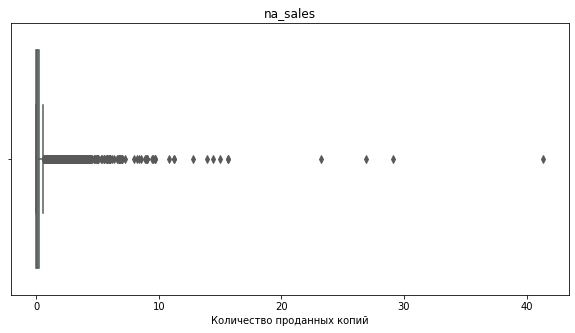

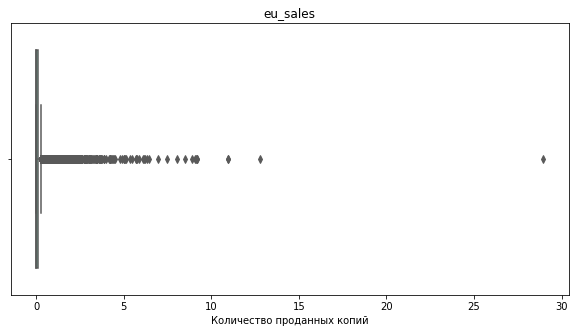

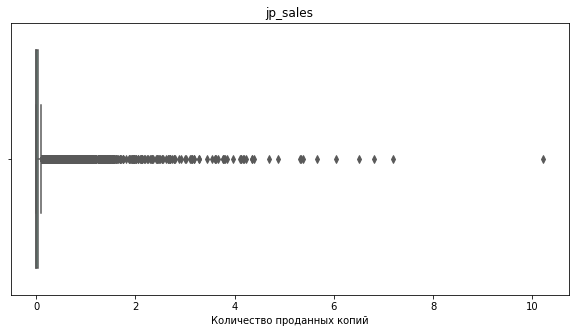

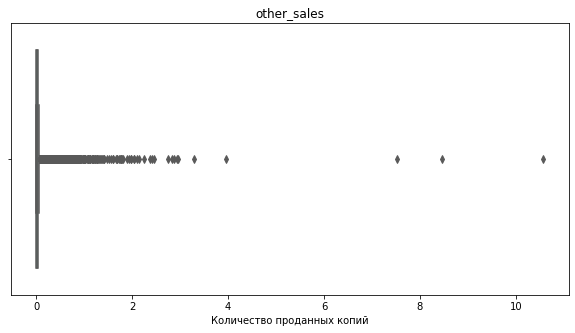

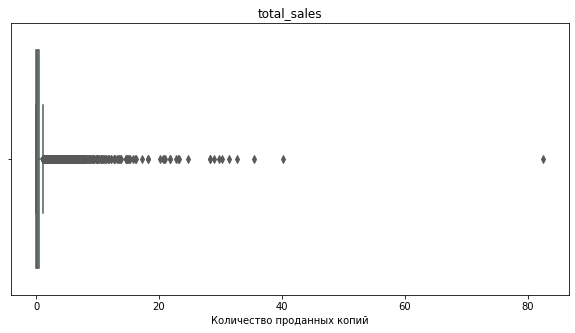

,na_sales,eu_sales,jp_sales,other_sales,total_sales
count,16567.000000,16567.000000,16567.000000,16567.000000,16567.000000
mean,0.263975,0.145814,0.078020,0.047567,0.535376
std,0.816474,0.505364,0.310068,0.187476,1.554281
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.060000
50%,0.080000,0.020000,0.000000,0.010000,0.170000
75%,0.240000,0.110000,0.040000,0.030000,0.470000
max,41.360000,28.960000,10.220000,10.570000,82.540000


In [23]:
# выбираем столбцы с продажи в разных регионах и общие продажи
sales = df[['na_sales', 'eu_sales', 'jp_sales', 'other_sales', 'total_sales']]

# создаем цикл, который построит графики
for column in sales:
    plt.figure(figsize=(10,5))
    sns.boxplot(data=df, x=df[column], palette="Set2")
    plt.title(column, size = 12)
    plt.xlabel('Количество проданных копий')
    plt.show()

# выводим информацию по средним показателям
sales.describe()

На всех графиках заметно, что есть игры, у которых продажи намного больше, чем у остальных. Однако удалять их не нужно, поскольку это игры, которые "выстрелили" и продавались значительно лучше. 

Средние значение у всех регионов значительно больше стандартного отклонения. Самые успешные игры сильно влияют на эти показатели, поскольку большинство игр имеют не очень большие показатели по продажам. 

[Перейти к оглавлению](#contents)

### Анализ игр по годам <a id='years'></a>

Посмотрим, как менялись продажи в зависимости от года. Для этого сгруппируем данные по годам и количеству выходивших игр в этот год, затем построим график.

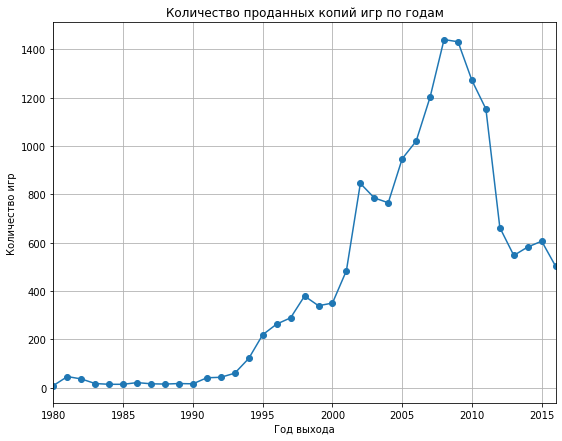

In [24]:
plt.figure(figsize=(9,7))
games_by_years = df.groupby('year_of_release')['name'].count()
games_by_years.plot(x ='year_of_release', y = 'name', style='o-', grid = True)
plt.title('Количество проданных копий игр по годам')
plt.xlabel('Год выхода')
plt.ylabel('Количество игр')
plt.show()

Игры начали выходить с 1980 года и их количество было минимально. Рост начался c 1990 года. Резкий скачок произошел после 2000 года, достигнув своего пика 2008 году. После 2009 года началось снижения количества выходящих игр, с резким падением в 2012 году. Похоже, последствия финансового кризиса повлияли и на игровую индустрию. Но уже в 2013-2015 годах заметно повышение числа игр. Данные за 2016 год неполные, поэтому пока нельзя судить о тенденции в этом году.

Поскольку необходимо сделать прогноз на будущий период, то стоит брать данные не полностью за все года. До начала 2000-х игры были, скорее, редкостью. Развитие технологий и распространение консолей среди более широкой аудитории дали больше возможностей для создания игр. Поэтому дальше стоит рассматривать игры выходившие уже после 2000 года. Чтобы определить более точно актуальный период, посмотрим на игровые платформы.

[Перейти к оглавлению](#contents)

### Анализ игровых платформ <a id='platforms'></a>

Сгруппируем платформы по продажам, отсортируем от большего к меньшему и выведем 10 с наибольшей прибылью, построив график.

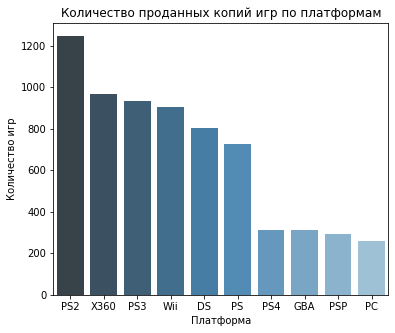

In [25]:
# группируем платформы по продаж и отбираем топ-10
platform = (df
            .pivot_table(index = 'platform', values = 'total_sales', aggfunc = 'sum')
            .sort_values(by = 'total_sales', ascending=False)
            .reset_index()
            .loc[:9]
           )

# рисуем график
plt.figure(figsize=(6,5))
sns.barplot(y='total_sales', x='platform', data = platform, palette='Blues_d')
plt.title('Количество проданных копий игр по платформам')
plt.xlabel('Платформа')
plt.ylabel('Количество игр')
plt.show()

Наиболее продаваемой платформой оказалась PS2, затем идут X360 и PS3 с разницей около 300 млн. копий. Шестерка лидеров значительно превосходит по продажам остальные платформы. Более новые платформы пока отстают от ранее выпущенных. Это связано с тем, что они меньше времени присутствуют на рынке.

Теперь посмотрим на продажи у этих платформ по годам. Для этого выберем из общей таблицы топ-10 платформ и сгруппируем по продажам по каждому году. Затем построим график, который покажет, как распределялись продажи по годам по каждой платформе.

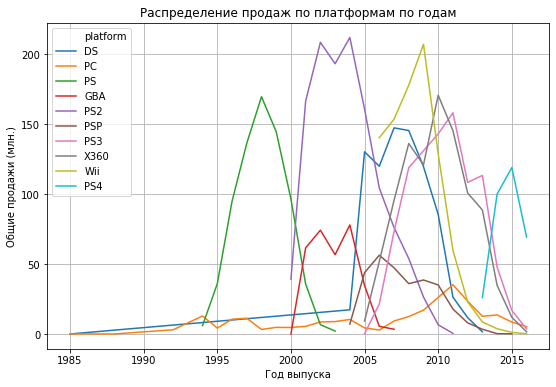

In [26]:
# выбираем топ-10 платформ по продажам
top_10_platform = df.loc[df['platform'].isin(['PS2', 'X360', 'PS3', 'Wii', 'DS', 'PS', 'PS4', 'GBA', 'PSP', 'PC'])]

# группируем продажи по году и платформе
sales_by_years = top_10_platform.groupby(['year_of_release', 'platform']).agg({'total_sales':'sum'}).reset_index()

# рисуем график
plt.figure(figsize=(9,6))
plt.grid(True)
sns.lineplot(data=sales_by_years, x='year_of_release', y='total_sales', hue='platform')
plt.title('Распределение продаж по платформам по годам')
plt.xlabel('Год выпуска')
plt.ylabel('Общие продажи (млн.)')
plt.show()

Практически все платформы имеют пиковые значения, когда было продано наибольшее число копий игр. GBA, PS2, DS, X360 и PS3 даже имеют по два пика, после которых идет резкое снижение продаж. Вероятно, это связано с выходом игр, которые были успешными и пользовались популярностью у покупателей. Интересно, что снижение продаж в большинстве случаев совпадает с выходом новой консоли. Самой "живучей" платформой является PC. Он продавалась на протяжении всего временного промежутка исследования. Остальные появлялись и затем уходили с рынка.

Посмотрим на распределение по всем платформам по количеству выходивших игр, таким образом оценим продолжительность жизни платформы.

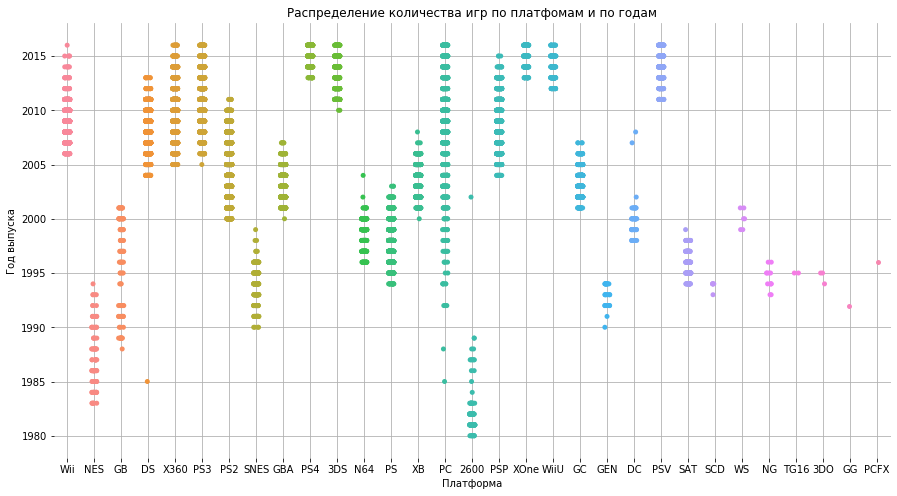

In [27]:
f, ax = plt.subplots(figsize=(15,8))
plt.title('Распределение количества игр по платфомам и по годам')
sns.despine(bottom=True, left=True)
sns.stripplot(x='platform', y='year_of_release',
              data=df, dodge=True, alpha=1, zorder=10, linewidth=0)
plt.xlabel('Платформа')
plt.ylabel('Год выпуска')
ax.grid(True)

Предположение о том, что после появления новой консоли влияет на старые поколения, особенно это касается в рамках одного производителя, похоже на истину. Спустя несколько лет поддержка старой платформы, как правило, прекращается.

Посмотрим на примере консолей PlayStation, сколько лет она существовала до выхода новой. Первая PS вышла в 1994 году, затем PS - в 2000 году, PS3 - в конце 2005 года, наконец, PS4 - в конце 2013 года. Можно предположить, в среднем период выхода новой консоли около 6 лет.

Проверим на другом производителе - Nintendo. Указаны домашние консоли и год выпуска:
1. NES - 1983;
2. SNES - 1990;
3. N64 - 1996;
4. GC - 2001;
5. Wii - 2006;
6. WiiU - 2012.

Проверим, предположение, посчитав разницу между первым и последним годом выпуска игр. Для этого сгруппируем данные по платформам и найдем разницу между годами. Также построим гистограмму, которая покажет, есть ли выбросы по продолжительности существования платформ. Скорее всего, они будут, т.к. PC существовала 30 лет, что не характерно для остальных платформ.

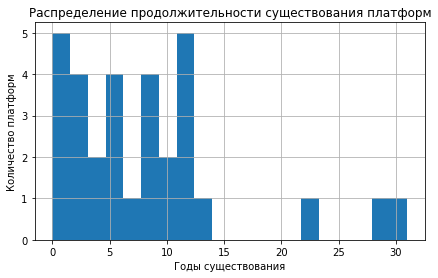

In [28]:
# группирем данные и меняем названия столбцов
platform_lifetime = df.groupby('platform').agg({'year_of_release':{'min', 'max'}}).reset_index()
platform_lifetime.columns = ['platform', 'fisrt_release_year', 'last_release_year']

# находим продолжительность жизни платформ и строим гистограмму
platform_lifetime['lifetime'] = platform_lifetime['last_release_year'] - platform_lifetime['fisrt_release_year']
plt.figure(figsize=(7,4))
platform_lifetime['lifetime'].hist(bins=20)
plt.title('Распределение продолжительности существования платформ')
plt.xlabel('Годы существования')
plt.ylabel('Количество платформ')
plt.show()

Как и предполагалось, есть несколько платформ, которые значительно отличаются от большинства по продолжительности существования. Это платформы с годами жизни больше 15 лет. Уберем их из выборки, чтобы они не влияли на данные. Затем найдем среднюю продолжительность жизни.

In [29]:
platform_lifetime_loc = platform_lifetime[platform_lifetime['lifetime'] < 15]
platform_lifetime_loc['lifetime'].mean().round(2)

6.14

Таким образом, актуальный период - это 6 лет. Именно столько, в среднем, живут платформы.

Данные для дальнейшего исследования будем брать с 2011 по 2016. Так в анализ попадут только последние поколения платформ. Это поможет построить прогноз на 2017 год.

[Перейти к оглавлению](#contents)

### Исследование актуального периода  <a id='current_period'></a>

Отфильтруем данные начиная с 2011 года.

In [30]:
df_actual = df[df['year_of_release'] >= 2011]

#### Исследование платформ <a id='current_platforms'></a>

Теперь сгруппируем данные за каждый год по суммарным продажам каждой платформы и построим график для определения перспективных консолей. Заполним пустые значения нулевыми в тех годах, когда консоли либо еще не вышли, либо уже прекратили выходить игры для них.

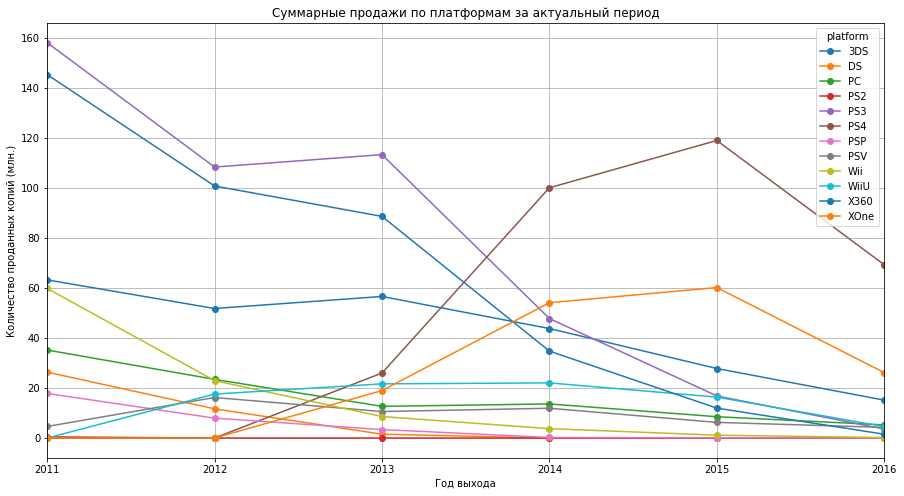

In [31]:
df_actual_pivot = (df_actual
                   .pivot_table(index='year_of_release', values= 'total_sales', columns = 'platform', aggfunc='sum')
                   .fillna(0)
                  )
df_actual_pivot.plot(style='o-', figsize=(15,8), grid = True)
plt.title('Суммарные продажи по платформам за актуальный период')
plt.xlabel('Год выхода')
plt.ylabel('Количество проданных копий (млн.)')
plt.show()

На графике заметно, что продажи растут у двух платформ - PS4 и XOne. Стремительно падают продажи у PS3, X360, Wii и PC. У PSV и 3DS также заметно снижение, хотя не такое стремительное, как у предыдущих платформ. Неплохо обстоят дела у WiiU. Но тоже заметна тенденция к снижению.

PS2, DS, PSP к 2016 году перестали выпускать игры, так что на них рассчитывать не стоит, как на перспективных кандидатов.

Таким образом, наиболее перспективными платформами являются - PS4 и XOne. Также стоит обратить внимание на WiiU, возможно, что она тоже продолжит рост или будет показывать стабильные показатели.

Посмотрим на распределение по глобальным продажам игр в разбивке по платформам, для этого построим ящики с усами.

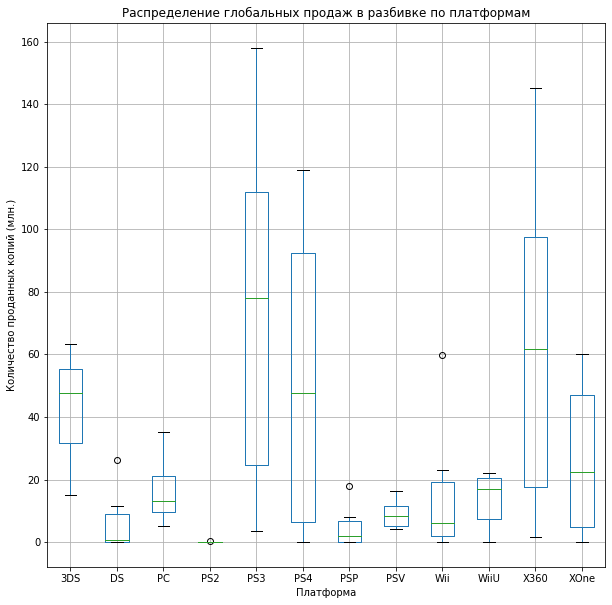

In [32]:
df_actual_pivot.boxplot(figsize=(10, 10))
plt.title('Распределение глобальных продаж в разбивке по платформам')
plt.xlabel('Платформа')
plt.ylabel('Количество проданных копий (млн.)')
plt.show()

Наибольшие продажи были у PS3, затем у X360 и PS4. Но стоит принять во внимание, что продажи у PS3 и X360 снижаются в то время, как консоль PS4 нового поколения, т.е. она только недавно вышла на рынок, значит в ближайшее время продажи будут расти, пока ей на смену не придут улучшенные версии. 

Медианное значение выше у X360, чем у PS4. Но продажи X360 падают, скорее всего, в ближайшее время новые игры перестанут выходить на этой консоли. Показатели PS4 "подпортил" 2013 год, когда она только вышла в конце года. На следующий год ее продажи выросли в 4 раза, забрав прибыль у PS3. 

Еще одна перспективная платформа - XOne, имеет более скоромный рост в 2014 году (в 3 раза увеличились продажи). Но и начальные продажи стартовали значительно на меньшем уровне, чем у PS4. Хотя они вышли с разницей в неделю. В 2015 году продалось почти в 2 раза больше игр на PS4, чем XOne. Т.е. рост у XOne более плавный, чем у PS4. 

У трех платформ: DS, PSP, Wii (PS2 не берем в расчет, выход игр прекратился после 2011 года на них) есть выбросы, которые выходят за границы усов. Скорее всего, на этих платформах выходили игры, которые пользовались бОльшей популярностью, чем средние игры каждой платформы. Поэтому продажи у таких игр значительно превосходят средние значения.

У WiiU медианное значение сдвинуто ближе к верхней границе, т.к. только неполные данные за 2016 значительно искажают картину: в среднем продажи у этой консоли около 19-20 млн. 

3DS имеет средние продажи около 50 млн. Но за последние 6 лет она падала по продажам во всем мире. Стоит отметить, что все-таки она имеет довольно высокие продажи, отсюда чуть скошенное ближе к вверху медианное значение.

Оставшиеся платформы - PS2, DS, PSP, прекратили выпускать игры.

[Перейти к оглавлению](#contents)

#### Исследование зависимости продаж и оценок <a id='current_platform'></a>

Посмотрим, влияют ли оценки критиков и пользователей на продажи на примере платформ PS4, XOne и WiiU: посчитаем значения корреляции и построим график зависимость параметров.

Корреляция для PS4


,critic_score,user_score,total_sales
critic_score,1.000000,0.557654,0.406568
user_score,0.557654,1.000000,-0.031957
total_sales,0.406568,-0.031957,1.000000


Корреляция для XOne


,critic_score,user_score,total_sales
critic_score,1.000000,0.472462,0.416998
user_score,0.472462,1.000000,-0.068925
total_sales,0.416998,-0.068925,1.000000


Корреляция для WiiU


,critic_score,user_score,total_sales
critic_score,1.00000,0.770080,0.348380
user_score,0.77008,1.000000,0.400219
total_sales,0.34838,0.400219,1.000000


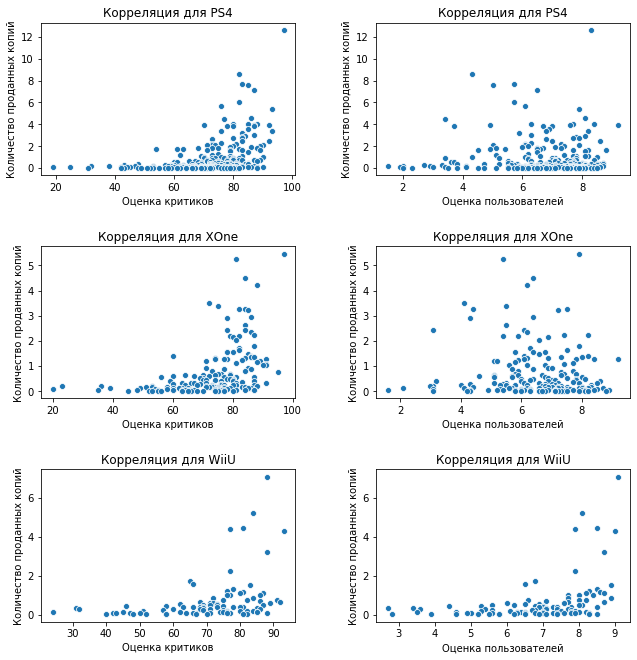

In [33]:
columns_platform = ['PS4', 'XOne','WiiU']
fig, axes = plt.subplots(nrows=(len(columns_platform)), ncols=2, figsize=(10,10))
fig.tight_layout(pad=5.0)
 
for i in range (len(columns_platform)): 
    # выводим корреляцию между оценками и продажами по трем платформам
    print('Корреляция для ' + columns_platform[i])
    correlation = df_actual[df_actual['platform'] == columns_platform[i]]
    display(correlation[['critic_score', 'user_score', 'total_sales']].corr())
    
    # строим графики 
    crit_score_df = df_actual.loc[df_actual['platform'] == columns_platform[i]]
    user_score_df = df_actual.loc[df_actual['platform'] == columns_platform[i]]
    ax1 = axes[i][0]
    ax2 = axes[i][1]
    sns.scatterplot(data=crit_score_df, x='critic_score', y='total_sales', ax = ax1)
    sns.scatterplot(data=user_score_df, x='user_score', y='total_sales', ax = ax2)
    ax1.set_title('Корреляция для '+ columns_platform[i])
    ax1.set_xlabel('Оценка критиков')
    ax1.set_ylabel('Количество проданных копий')
    ax2.set_title('Корреляция для '+ columns_platform[i])
    ax2.set_xlabel('Оценка пользователей')
    ax2.set_ylabel('Количество проданных копий')

Начнем с PS4. Судя по графикам и коэффициенту корреляции, практически нет зависимости между оценками пользователей. Интересно, при низких оценках у пользователей есть игры, которые имеют высокие продажи. Это заметно и по отрицательному коэффициенту корреляции.

Оценки критиков и продажи имеют бОльшую корреляцию между собой. Похоже, что перед покупкой пользователи могут прислушаться к мнению критиков.

Теперь посмотрим на зависимость от оценок по XOne. Судя по диаграмме, зависимость между оценками критиков и продажами существует, пусть и не сильная. Есть игры, которые выделяются и по оценке, и по продажам. Возможно, здесь существует обратная связь: критики обратили внимание на игру из-за высоких продаж.

По оценкам игроков аналогичная ситуация, что и у PS4 - они практически не влияют на продажи.

Коэффициенты подтверждают выводы, сделанные по графикам. Можно отметить, что у XOne чуть больше зависимость от мнения критиков и пользователей, чем у PS4, но не существенно.

Перейдем к WiiU. Здесь ситуация другая. Оценки критиков и пользователей примерно одинаково соотносятся с продажами. Оценки пользователей намного сильнее влияют на число проданных копий, чем у PS4 и XOne. Кроме того, в отличии от двух других платформ имеют положительную зависимость. Т.е. чем выше оценка, тем выше продажи.
    
Оценки критиков в меньшей степени влияют на продажи, чем у двух других платформ.

[Перейти к оглавлению](#contents)

#### Исследование распределения игр по жанрам <a id='current_genre'></a>

Посмотрим на распределение игр по жанрам. Для этого сгруппируем данные и построим столбчатую диаграмму.

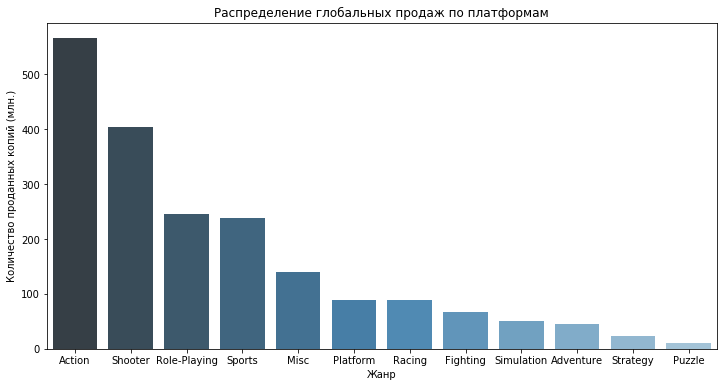

In [34]:
genre_sales = (df_actual
              .pivot_table(index='genre', values='total_sales', aggfunc= {'sum'})
              .reset_index()
              .sort_values(by='sum', ascending=False)
              )
f, ax = plt.subplots(figsize=(12, 6))
sns.barplot(x = 'genre', y='sum', data = genre_sales, palette='Blues_d')
plt.title('Распределение глобальных продаж по платформам')
plt.xlabel('Жанр')
plt.ylabel('Количество проданных копий (млн.)')
plt.show()

Наиболее прибыльными с большим отрывом являются игры в жанре action, затем shooter также с большим отрывом от жанра на третьем месте (role-playing). Значит, что пользователи предпочитают игры, в которых делается акцент на физические особенности игрока (жанры action и shooter) и на прокачку способностей персонажа/персонажей (жанр role-playing). Замыкают топ-5 игр спортивные игры, которые немного отстают от ролевых, и игры, жанр которых определен как "разное".

Хуже всего продаются puzzle и strategy.

Интересно, что на создание игр в жанрах action и shooter производители тратят намного больше денег и времени, чем на puzzle-игры. Вероятно, высокое качество, сложность, приближенность к реальности привлекают игроков сильнее. Также может играть эффект ожидания, когда, чтобы поиграть в игру, ее нужно дождаться. Повышается ценность игры и ее эксклюзивность.

[Перейти к оглавлению](#contents)

**Вывод**

В ходе исследования были выявлены следующие особенности:
1. Наибольшее распространение игры получили после 2000 года. На игровую индустрию оказывает влияние экономическая ситуация в мире: кризис 2008 года снизил продажи;
2. Самой продаваемой платформой на конец 2016 года является PS2, затем идут X360 и PS3. Но выпуск игр у PS2 прекратился, продажи у X360 и PS3 стремительно падают. Причиной является выход платформ нового поколения, которые заменяют прошлые;
3. Как правило, "срок службы" платформ одного поколения составляет 6 лет;
4. Наиболее перспективными платформами являются PS4, XOne и WiiU;
5. Оценки пользователей практически не влияют на продажи платформ PS4 и XOne в то время, как пользователи WiiU обращают внимание на отзывы игроков, пусть и не сильно полагаются на них. Мнение критиков важнее для игроков PS4 и XOne, чем для WiiU. Но все же сложно говорить, что это влияние сильное;
6. Наиболее популярные жанры - action и shooter, а менее - puzzle и strategy.

[Перейти к оглавлению](#contents)

## 4. Составление портрета пользаветеля каждого региона <a id="users"></a>

Прежде чем определить портрет пользователя для каждого региона, посмотрим в целом на продажи по каждому региону и годам.

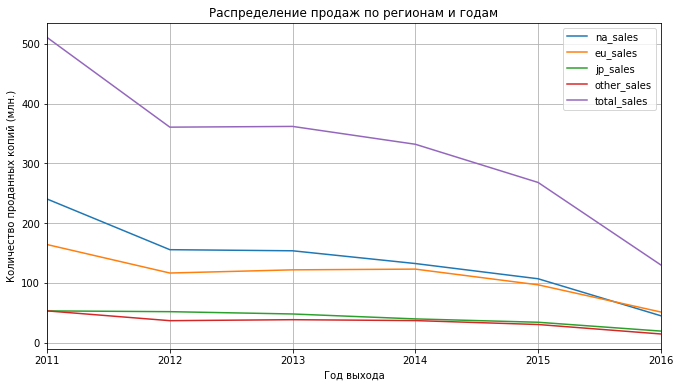

In [35]:
sales_by_region = df_actual[[x for x in df_actual.columns if 'sales' in x] + ['year_of_release']]
sales_by_region.groupby('year_of_release').sum().plot(figsize = (11, 6), grid = True)
plt.title('Распределение продаж по регионам и годам')
plt.xlabel('Год выхода')
plt.ylabel('Количество проданных копий (млн.)')
plt.show()

Самое большое количество проданных копий изначально было в Северной Америке, но в 2015 году продажи в этом регионе практически сравнялись с продажами в Европе. Продажи в Японии практически идут на одном уровне со всеми остальными регионами вместе взятыми.

Продажи в Северной Америке и Европе повторяют кривую общих продаж. Количество проданных копий в Японии и остальных регионах почти не меняется на протяжении исследуемого периода.

Напишем функцию, которая будет строить столбчатую диаграмму с топ-5 платформ и круговую, которая будет отображать долю, занимаемую платформы среди топ-5.

In [36]:
def graphics(parameter, sales, data, title, region):
    # столбатая диаграмма
    f, ax = plt.subplots(figsize=(5, 4))
    sns.barplot(x = parameter, y=sales, data = data, palette='Blues_d')
    plt.title('Топ-5 '+ title + ' в '+ region)
    plt.xlabel('Платформа')
    plt.ylabel('Количество проданных копий (млн.)')
    plt.show()
    
    # круговая диаграмма
    labels = data[parameter]
    sizes = data[sales]
    fig1, ax1 = plt.subplots(figsize=(5,5))
    ax1.pie(sizes, labels=labels, autopct='%1.1f%%', pctdistance=0.7)
    ax1.axis('equal')
    plt.show()

###  Северная Америка <a id="america"></a>

#### Самые популярные платформы (топ-5)

Сгруппируем данные по платформам и построим графики.

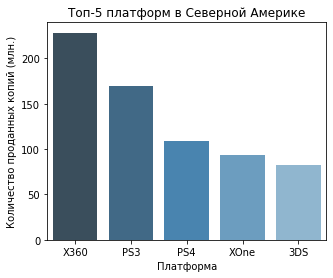

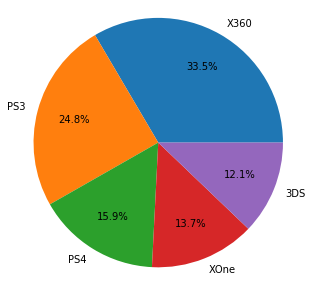

In [37]:
america_platforms = (df_actual
                     .groupby('platform')['na_sales'].sum()
                     .reset_index()
                     .sort_values(by='na_sales', ascending=False)
                     .head(5)
                    )

graphics('platform', 'na_sales', america_platforms, 'платформ', 'Северной Америке')

Самой популярной платформой в Северной Америке является X360, она занимает треть от продаж топ-5 платформ. Затем идет PS3 занимающая четверть продаж. Оставшиеся 42% три платформы (PS4, XOne и 3DS) делят практически поровну - 16%, 14% и 12% соответственно.

[Перейти к оглавлению](#contents)

#### Самые популярные жанры (топ-5)

Теперь сгруппируем данные по жанрам и посмотрим на 5 самых популярных и их процентное соотношение между собой.

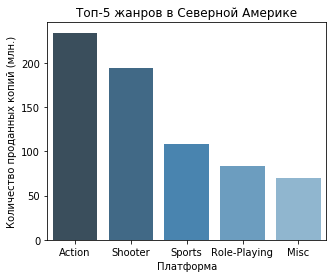

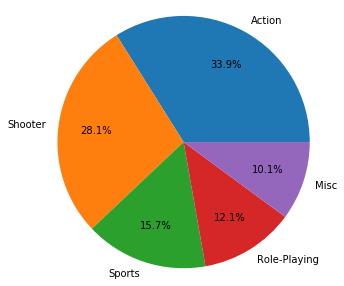

In [38]:
america_genre = (df_actual
                     .groupby('genre')['na_sales'].sum()
                     .reset_index()
                     .sort_values(by='na_sales', ascending=False)
                     .head(5)
                    )
graphics('genre', 'na_sales', america_genre, 'жанров', 'Северной Америке')

Аналогично данным по всем регионам в Америке популярными являются игры в жанрах action (34%) и shooter (28%). Далее спортивные (16%) и ролевые игры (12%) поменялись местами по сравнению с общим рейтингом. И замыкает топ-5, как и общий, - "разные" игры с 10%.

[Перейти к оглавлению](#contents)

#### Влияет ли рейтинг ESRB на продажи?

Посмотрим, как рейтинг ESRB влияет на продажи в Северной Америке.

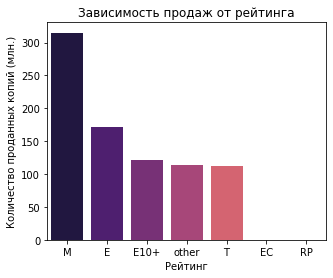

In [39]:
america_esrb = (df_actual
                     .groupby('rating')['na_sales'].sum()
                     .reset_index()
                     .sort_values(by='na_sales', ascending=False)
                    )

# создаем функцию построения рейтинга
def rating(sales, data):
    f, ax = plt.subplots(figsize=(5, 4))
    sns.barplot(x = 'rating', y=sales, data = data, palette='magma')
    plt.title('Зависимость продаж от рейтинга')
    plt.xlabel('Рейтинг')
    plt.ylabel('Количество проданных копий (млн.)')
    plt.show()
    
rating('na_sales', america_esrb)

Большинство игр продаются с рейтингом "для взрослых" (более 300 млн. копий), т.е. для людей старше 18 лет, т.к. могут содержать сцены насилия, грубую ненормативную лексику и т.д. Затем идут игры с рейтингом "для всех" (около 175 млн. копий) и "для всех от 10 лет и старше" (порядка 125 млн. копий). У практически 100 млн. не определен рейтинг (заменяли пустые значения на "other"). Чуть меньше копий было продано с рейтингом "подростки", т.е. для всех, кто старше 13 лет.

**Портрет пользователя из Северной Америки** выглядит так: **играет на X360 или PS3 в action и shooter, которые имеют возрастной рейтинг 18+.**

[Перейти к оглавлению](#contents)

###  Европа <a id="europe"></a>

Перейдем к изучению пользователя из Европы.

#### Самые популярные платформы (топ-5)

Посмотрим на распределение по платформам.

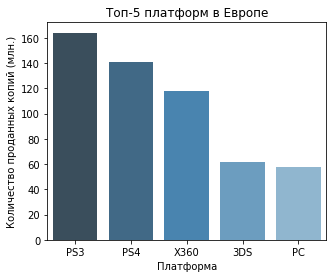

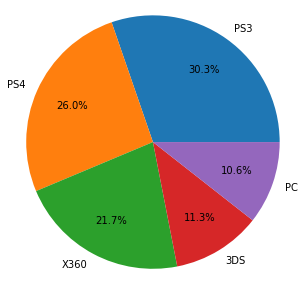

In [40]:
europe_platforms = (df_actual
                     .groupby('platform')['eu_sales'].sum()
                     .reset_index()
                     .sort_values(by='eu_sales', ascending=False)
                     .head(5)
                    )
graphics('platform', 'eu_sales', europe_platforms, 'платформ', 'Европе')

Сразу заметно отличие по распределению консолей Европы от Америки. Здесь отдают предпочтения консолям компании Sony - PS3 и PS4 с долями 30% и 26% соответственно, затем уже идет X360 с 22%. 3DS имеет меньшую долю, чем в Америке, но занимает при этом 4 место, опережая PC меньше, чем на 1%.

[Перейти к оглавлению](#contents)

#### Самые популярные жанры (топ-5)

Выясним, какие жанр наиболее популярны в Европе.

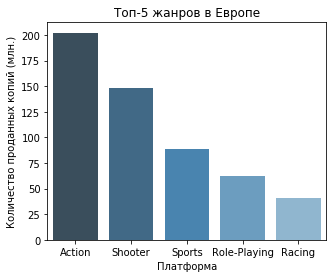

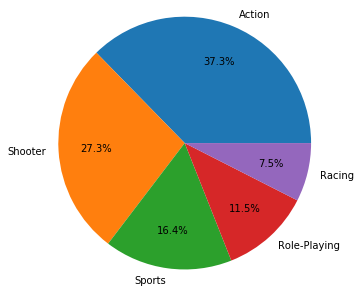

In [41]:
europe_genre = (df_actual
                     .groupby('genre')['eu_sales'].sum()
                     .reset_index()
                     .sort_values(by='eu_sales', ascending=False)
                     .head(5)
                    )
graphics('genre', 'eu_sales', europe_genre, 'жанров', 'Европе')

Первые 4 места распределились аналогично Америке, хотя с чуть большим преобладанием экшн-игр, остальные три жанра приблизительно имеют похожее соотношение. Отличием стало появление "гонок" среди топ-5 жанров.

[Перейти к оглавлению](#contents)

#### Влияет ли рейтинг ESRB на продажи?

Оценим продажи в соответствии с рейтингом ESRB.

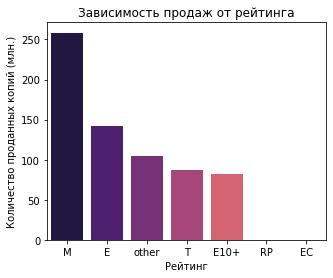

In [42]:
europe_esrb = (df_actual
                     .groupby('rating')['eu_sales'].sum()
                     .reset_index()
                     .sort_values(by='eu_sales', ascending=False)
                    )
rating('eu_sales', europe_esrb)

Снова большинство игр продаются с рейтингом 18+, но копий меньше на 50 млн., чем в Северной Америке. Затем идут игры с рейтингом "для всех" (менее 150 млн. копий) и игры без рейтинга (100 млн. копий). Потом идут игры для подростков и игры от 10 лет по 90 и 85 млн. копий соответственно.

**Портрет пользователя из Европы** получается следующий: **играет на PS3 или PS4 в action и shooter, которые имеют возрастной рейтинг 18+.**

[Перейти к оглавлению](#contents)

###  Япония <a id="japan"></a>

Посмотрим на рынок Японии.

#### Самые популярные платформы (топ-5)

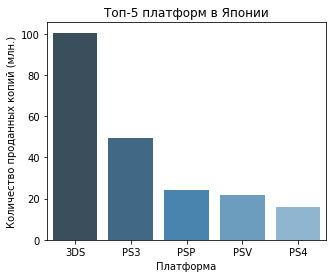

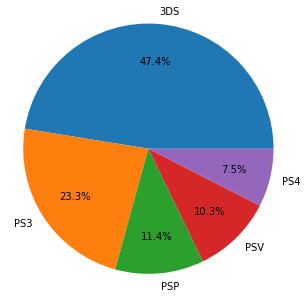

In [43]:
japan_platforms = (df_actual
                     .groupby('platform')['jp_sales'].sum()
                     .reset_index()
                     .sort_values(by='jp_sales', ascending=False)
                     .head(5)
                    )
graphics('platform', 'jp_sales', japan_platforms, 'платформ', 'Японии')

Значительно отличается рейтинг самых популярных платформ. Абсолютным лидером в Японии является платформ 3DS от Nintendo, которая занимает почти половину (47,5%) среди топ-5 платформ. Затем идут 4 консоли от Sony: PS3 (23%), PSP(11%), PSV (10%) и PS4 (7,5%).

Обе компании являются японскими, поэтому не удивительно их преобладание на рынке страны.

[Перейти к оглавлению](#contents)

#### Самые популярные жанры (топ-5)

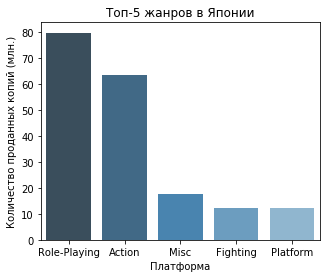

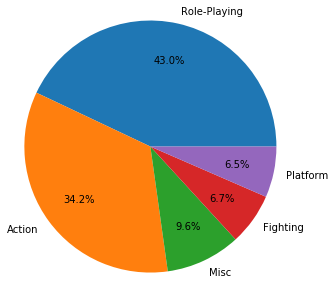

In [44]:
japan_genre = (df_actual
                     .groupby('genre')['jp_sales'].sum()
                     .reset_index()
                     .sort_values(by='jp_sales', ascending=False)
                     .head(5)
                    )
graphics('genre', 'jp_sales', japan_genre, 'жанров', 'Японии')

Снова изменения от привычного порядка: ролевые игры опередили экшн, причем почти на 10%. Основную долю занимают эти два жанра. Остальные 23% неожиданно распределены между играми с жанром "разные", fighting (жанр, в котором нужно сразиться с соперником, как правило, один на один в ограниченном пространстве) и platformer (основной чертой игрового процесса является прыгание по платформам, лазанье по лестницам, собирание предметов, необходимых для завершения уровня).

[Перейти к оглавлению](#contents)

#### Влияет ли рейтинг ESRB на продажи?

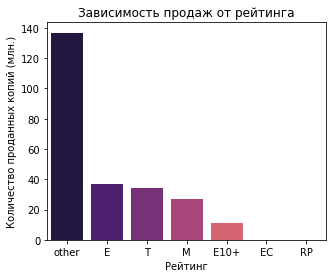

In [45]:
japan_esrb = (df_actual
                     .groupby('rating')['jp_sales'].sum()
                     .reset_index()
                     .sort_values(by='jp_sales', ascending=False)
                    )
rating('jp_sales', japan_esrb)

Снова игроки из Япония отличаются. Большинство продаваемых игр не имеют рейтинг от ESRB. Получается, что это единственный регион, где рейтинг от игровой ассоциации не играет никакой роли. Скорее всего, это связано с тем, что ассоциация ESRB имеет расположение в США и Канаде. Рынки Америки и Европы тесно взаимосвязаны не только среди игр, поэтому рейтинг также имеет значение и для европейцев. А Япония не придерживается рейтингов, установленных этой ассоциацией.

Также интересно, что игры с рейтингом "для всех" и "подростки" продаются лучше, чем игры 18+.

Очень отличающийся **портрет пользователя из Япония** выглядит вот так: **играет на 3DS в ролевую игру или экшн, которые не имеют возрастного рейтинга от ESRB.**

[Перейти к оглавлению](#contents)

**Вывод**

В ходе исследования трех регионов можно заключить следующее:
1. Портреты пользователей из Северной Америки и Европы довольно похожи между собой: оба играют в action и shooter, которые имеют возрастной рейтинг 18+. Даже практически на одинаковых платформах. В Америке большей популярностью пользуется X360, когда европейцы играют на двух последних версиях PS.
2. Игроки из Японии разительно отличаются от американцев и европейцев. Они не обращают внимание на рейтинг от ESRB, почти половина из них играет на 3DS в ролевые игры.

Похожесть рынков Америки и Европы, а также различия между двумя этими регионами и Японии обусловлено экономическими, культурными и географическими причинами. Стоит это учитывать при планировании рекламных кампаний и стратегии продвижения.

[Перейти к оглавлению](#contents)

## 5. Проверка гипотез <a id='hypothesis'></a>

### Гипотеза 1: средние пользовательские рейтинги платформ Xbox One и PC одинаковые <a id='hypothesis_1'></a>

Сформируем нулевую и альтернативную гипотезы для проверки равенства средних:

H0 - средние пользовательские рейтинги платформ Xbox One и PC равны;

H1 - средние пользовательские рейтинги платформ Xbox One и PC не равны.

Для начала сформируем две выборки для каждой платформы.

In [46]:
user_score_xbox = df_actual.loc[df_actual.loc[:, 'platform'] == 'XOne']['user_score']
user_score_pc = df_actual.loc[df_actual.loc[:, 'platform'] == 'PC']['user_score']

Перед началом проверки гипотезы убедимся, что дисперсии двух выборок не отличаются друг от друга более, чем на 5%.

In [47]:
variance_xbox = np.var(user_score_xbox, ddof=1)
variance_xbox

1.9069968429360695

In [48]:
variance_pc = np.var(user_score_pc, ddof=1)
variance_pc

2.5759813597606884

Дисперсии выборок друг от друга отличаются более 5%, поэтому при проверке гипотез параметр `equal_var` установим False.

Теперь приступим к проверке гипотезы.

In [49]:
alpha  = 0.05
results = st.ttest_ind(user_score_xbox, user_score_pc, equal_var = False)
print('p-значение:', results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: nan
Не получилось отвергнуть нулевую гипотезу


Не удалось опровергнуть, что средние пользовательские рейтинги платформ Xbox One и PC равны.

[Перейти к оглавлению](#contents)

### Гипотеза 2: средние пользовательские рейтинги жанров Action и Sports разные <a id='hypothesis_2'></a>

Теперь проверим еще одну гипотезу о равенстве средних.

H0 - средние пользовательские рейтинги жанров Action и Sports равны;

H1 - средние пользовательские рейтинги жанров Action и Sports не равны.

Сформируем выборки для анализа.

In [50]:
user_score_action = df_actual.loc[df_actual.loc[:, 'genre'] == 'Action']['user_score']
user_score_sports = df_actual.loc[df_actual.loc[:, 'genre'] == 'Sports']['user_score']

Посмотрим на дисперсии в двух выборках.

In [51]:
variance_action = np.var(user_score_action, ddof=1)
variance_action

1.8013857346961206

In [52]:
variance_sports = np.var(user_score_sports, ddof=1)
variance_sports

2.8825095404015264

Дисперсии сильно различаются между собой, поэтому ставим `equal_var` = False.

In [53]:
alpha  = 0.05
results = st.ttest_ind(user_score_action, user_score_sports, equal_var = False)
print('p-значение:', results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: nan
Не получилось отвергнуть нулевую гипотезу


Получается, нельзя утверждать, что средние пользовательские рейтинги жанров Action и Sports равны.

[Перейти к оглавлению](#contents)

**Вывод**

Были проверены две гипотезы о равенстве средних пользовательских оценок. В первом случае не удалось отвергнуть гипотезу о равенстве рейтингов пользователей платформ Xbox One и PC. А утверждение - средние пользовательские рейтинги жанров Action и Sports равны, при проверке второй гипотезы было отвергнуто.

[Перейти к оглавлению](#contents)

## 6. Общий вывод и рекомендации <a id='conclusion'></a>

1. Для анализа были предоставлены данные по продажам компьютерных игр для выявления потенциально прибыльных продуктов.
2. Было установлено, что средняя продолжительность жизни платформы составляет 6 лет. Поэтому стоит делать ставку на платформы, вышедшие не так давно, а именно: PS4, XOne, дата релиза - конец 2013 года, и WiiU, дата релиза - конец 2012 года.
3. Оценки пользователей не влияют на продажи, к мнению критиков редко, но все же прислушиваются.
4. При продаже консолей, игр разных жанров стоит учитывать, на каком рынке они будут продаваться. Пользователи в Северной Америке и Европе похожи. Стоит только делать акцент на платформе от Майкрософт - XOne для американского рынка в то время, как европейцы с радостью играют на консолях PlayStation. Жанры в обоих регионах также практически совпадают - action и shooter доминируют на этих рынках.
5. Большинство самых продаваемых игр в Европе и Америке имеют рейтинг 18+.
6. Япония отличается от двух рынков. Игроки этой страны отдают предпочтение консоли от Nintendo, поэтому здесь, скорее всего, лучше пойдут продажи консоли нового поколения от этой компании - WiiU. Также японцам следует предлагать игры в жанре role-playing, также неплохо будут продаваться экшн-игры. Кроме того, большинство игр в Японии не имеют рейтинга от ESRB, который не влияет на продажи.
7. Во время анализа были протестированы две гипотезы. Гипотезу "средние пользовательские рейтинги платформ Xbox One и PC равны" не удалось опровергнуть. Результат проверки второй гипотезы показал, что нельзя утверждать, что средние пользовательские рейтинги жанров Action и Sports равны.

[Перейти к оглавлению](#contents)